In this tutorial we will explore the basic features of **Elegy**. If you are a Keras user you should feel at home, if you are currently using Jax or Haiku things will appear much more streamlined. To get started you will first need to install the following dependencies:

In [ ]:
! pip install elegy dataget matplotlib

Note that Elegy doesn't depend on `jax` since there are both `cpu` and `gpu` version you can choose from so you will need to install it separately.

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need to download and load the data into memory. Here we will use `dataget` for simplicity but you can use you favorite datasets library.

In [1]:
import dataget

X_train, y_train, X_test, y_test = dataget.image.mnist(global_cache=True).get()

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

X_train: (60000, 28, 28) uint8
y_train: (60000,) uint8
X_test: (10000, 28, 28) uint8
y_test: (10000,) uint8


In this case `dataget` loads the data from Yann LeCun's website.

## Creating the Model
Now that we have the data we can define our model. In Elegy you can do this by inheriting from `elegy.Module` and defining a `call` method. This method should take in some inputs, perform a series of transformation using Jax and Haiku expressions, and returns the outputs of the network. In this example we will create a simple 2 layer MLP using Haiku modules: 

In [2]:
import jax.numpy as jnp
import jax
import haiku as hk
import elegy

class MLP(elegy.Module):
    """Standard LeNet-300-100 MLP network."""
    def __init__(self, n1: int = 300, n2: int = 100, **kwargs):
            super().__init__(**kwargs)
            self.n1 = n1
            self.n2 = n2
    
    def call(self, image: jnp.ndarray) -> jnp.ndarray:
        
        image = image.astype(jnp.float32) / 255.0

        mlp = hk.Sequential(
            [
                hk.Flatten(),
                hk.Linear(self.n1),
                jax.nn.relu,
                hk.Linear(self.n2),
                jax.nn.relu,
                hk.Linear(10),
            ]
        )
        return mlp(image)

Here we are using `Sequential` to stack two layers with `relu` activations and a final `Linear` layer with `10` units that represents the logits of the network. This code should feel familiar to most Keras / PyTorch users, the main difference here is that instead of assigning layers / modules as fields inside `__init__` and later using them in `call` / `forward`, here we can just use them inplace since Haiku tracks the state for us "behind the scenes". Writing model code in Elegy / Haiku often feels easier since there tends to be a lot less boilerplate thanks to Haiku hooks. For a premier on Haiku please refer to this [Quick Start](https://github.com/deepmind/dm-haiku#quickstart).

**Note** <br>
`elegy.Module` is just a thin wrapper over `haiku.Module` that adds certain Elegy-related functionalities, you can inherit from from `haiku.Module` instead if you wish, just remember to also rename `call` to `__call__`

Now that we have this module we can create an Elegy `Model`.

In [3]:
from jax.experimental import optix

model = elegy.Model(
    module=lambda: MLP(n1=300, n2=100),
    loss=[
        elegy.losses.SparseCategoricalCrossentropy(from_logits=True),
        elegy.regularizers.GlobalL2(l=1e-4),
    ],
    metrics=lambda: elegy.metrics.SparseCategoricalAccuracy(),
    optimizer=optix.rmsprop(1e-3),
)

Much like `keras.Model`, an Elegy Model is tasked with performing training, evalaution, and inference. The constructor of this class accepts most of the arguments accepted by `keras.Model.compile` as you might have seen but there are some notable differences:

1. It requires you to pass a `module` as first argument.
2. Loss can be a list even if we don't have multiple corresponding outputs/labels, this is because Elegy exposes a more flexible system for defining losses and metrics based on Dependency Injection.

You might have notice some weird `lambda` expressions around `module` and `metrics`, these arise because Haiku prohibits the creation of `haiku.Module`s outside of a `haiku.transform`. To go around this restriction we just defer instantiation of these object by wrapping them inside a `lambda` and calling them later. For convenience both the `elegy.Module` and `elegy.Metric` classes define a `defer` classmethod that which you can use to make things more readable:

In [4]:
model = elegy.Model(
    module=MLP.defer(n1=300, n2=100),
    loss=[
        elegy.losses.SparseCategoricalCrossentropy(from_logits=True), 
        elegy.regularizers.GlobalL2(l=1e-4),
    ],
    metrics=elegy.metrics.SparseCategoricalAccuracy.defer(),
    optimizer=optix.rmsprop(1e-3),
)

## Training the Model
Having our `model` instance ready we now need to pass it some data to start training. Like in Keras this is done via the `fit` method which contains more or less the same signature. We try to be as compatible with Keras as possible here but also remove a lot of the Tensorflow specific stuff. The following code will train our model for `100` epochs while limiting each epoch to `200` steps and using a batch size of `64`:

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[elegy.callbacks.ModelCheckpoint("model", save_best_only=True)],
)

```
...

Epoch 99/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0094 - loss: 0.0105 - sparse_categorical_accuracy: 0.9958 - sparse_categorical_crossentropy_loss: 0.0011 - val_l2_regularization_loss: 0.0094 - val_loss: 0.0094 - val_sparse_categorical_accuracy: 0.9813 - val_sparse_categorical_crossentropy_loss: 7.4506e-09
Epoch 100/100
200/200 [==============================] - 1s 5ms/step - l2_regularization_loss: 0.0094 - loss: 0.0271 - sparse_categorical_accuracy: 0.9966 - sparse_categorical_crossentropy_loss: 0.0177 - val_l2_regularization_loss: 0.0094 - val_loss: 0.0094 - val_sparse_categorical_accuracy: 0.9806 - val_sparse_categorical_crossentropy_loss: 4.4703e-08                             
```

We've ported Keras beloved progress bar and also implemented its `Callback` and `History` APIs. `fit` returns a `history` object which we will use next to visualize how the metrics and losses evolved during training.

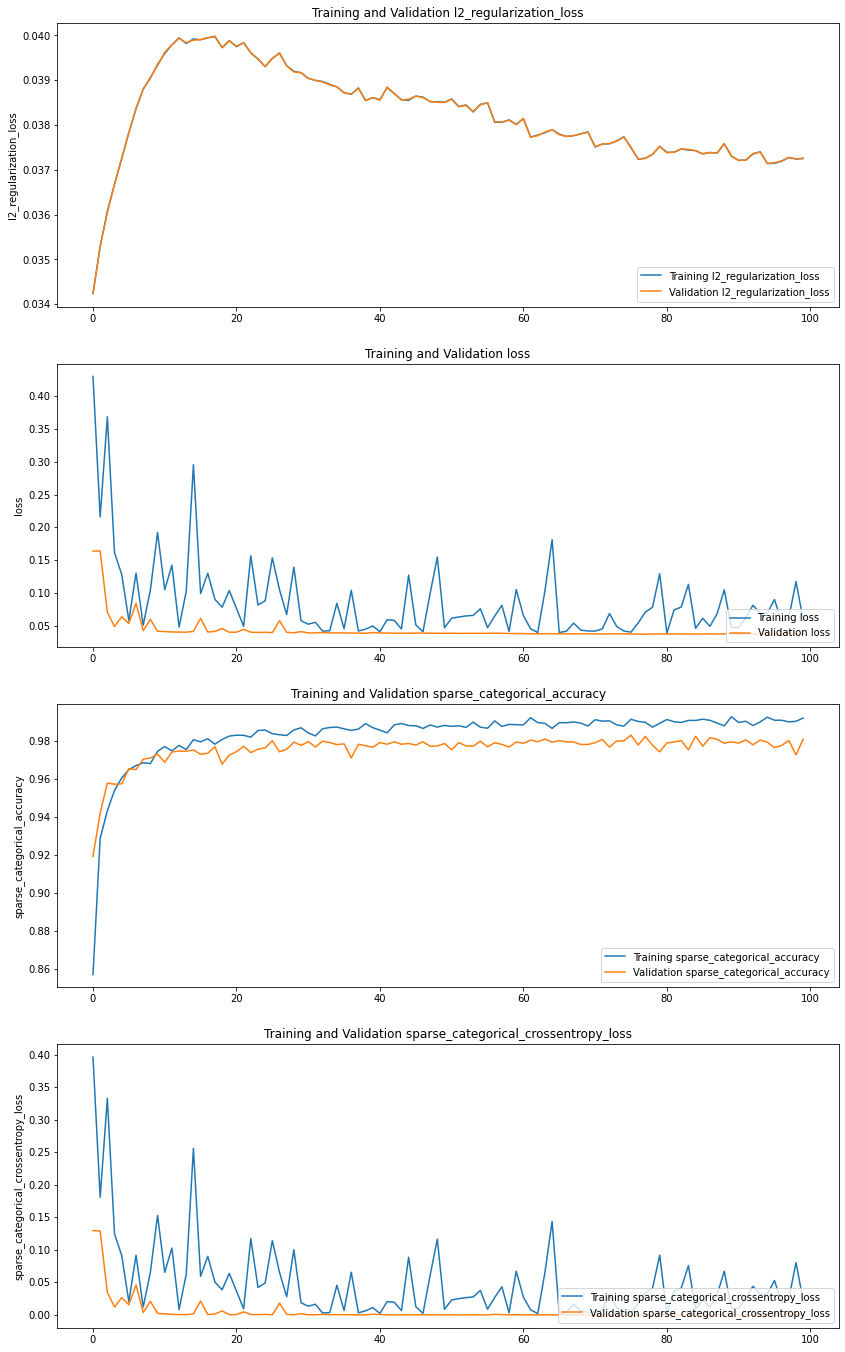

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

## Doing Inference

Having our trained model we can now get some samples from the test set and generate some predictions. First we will just pick some random samples using `numpy`:

In [13]:
import numpy as np

idxs = np.random.randint(0, 10000, size=(9,))
x_sample = X_test[idxs]

Here we selected `9` random images. Now we can use the `predict` method to get their labels:

In [14]:
y_pred = model.predict(x=x_sample)

Easy right? Finally lets plot the results to see if they are accurate.

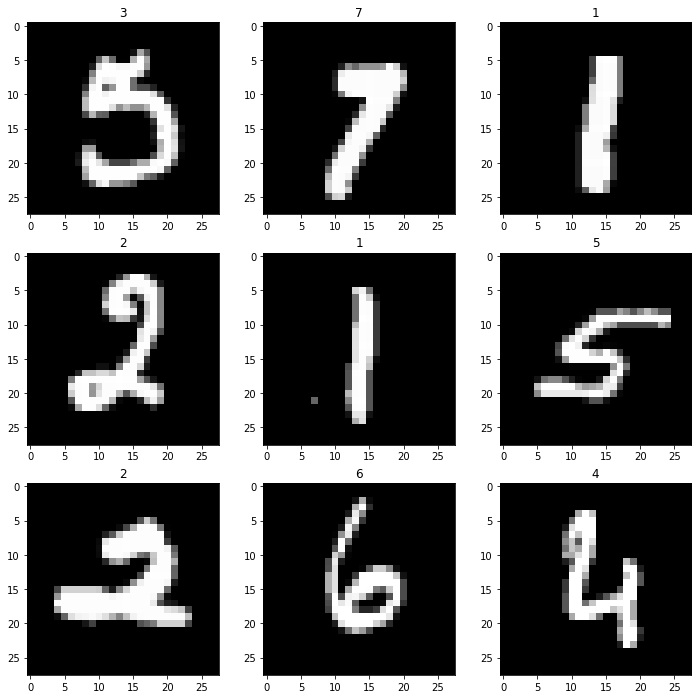

In [15]:
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")

Perfect!

## Loading Saved Model
Since we used `elegy.callbacks.ModelCheckpoint` we can always restore our model from disk in the future.

In [16]:
# current model reference
print("current:", model)

model = elegy.model.load("model")

# new model reference
print("new:    ", model)

# check that it works!
model.predict(x=x_sample).shape

current: <elegy.model.Model object at 0x7ff75daab550>
new:     <elegy.model.Model object at 0x7ff780d69fd0>


(9, 10)

We hope you've enjoyed this tutorial.

## Next Steps
Elegy is still in a very early stage, there are probably tons of bugs and missing features but we will get there. If you have some ideas or feedback on the current design we are eager to hear from you, feel free to open an issue.